# Synopsis

We investigate similarities among novel chapters (bags) using hieararchical agglomerative clustering (HAC). The essential parameter in this kind of clustering (i.e. vs. flat clustering, such as k-means) is the choice of linkage method. Linkage methods concern the rules by which pairs of coordinates are considered to be part of a group. We use the Ward method, which minimizes the variance among links. 

# Configuration

In [11]:
db_file = "/sfs/qumulo/qhome/sk5be/DS5559/HarryPotter.db"
titleHP = "/sfs/qumulo/qhome/sk5be/DS5559/booktitle_HP.csv"

# Libraries

In [3]:
import pandas as pd
import sqlite3

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

# Pragmas

In [4]:
%matplotlib inline

# Process

In [41]:
with sqlite3.connect(db_file) as db:
    bags = pd.read_sql("SELECT * FROM bag", db, index_col='bag_id')
    tfidf = pd.read_sql("SELECT * FROM tfidf_small", db, index_col=['bag_id','term_id'])

## Unpack TFIDF

In [42]:
TFIDF = tfidf.unstack()
TFIDF.columns = TFIDF.columns.droplevel(0)

## Get labels for the display

In [43]:
for i in range(0,len(bags)):
    if bags.loc[i,'book_num'] == 0:
        bags.loc[i,'book_str'] = "1: The Sorcerer's Stone"
    if bags.loc[i,'book_num'] == 1:
        bags.loc[i,'book_str'] = "2: The Chamber of Secrets"
    if bags.loc[i,'book_num'] == 2:
        bags.loc[i,'book_str'] = "3: The Prisoner of Azkaban"
    if bags.loc[i,'book_num'] == 3:
        bags.loc[i,'book_str'] = "4: The Goblet of Fire"
    if bags.loc[i,'book_num'] == 4:
        bags.loc[i,'book_str'] = "5: The Order of the Phoenix"
    if bags.loc[i,'book_num'] == 5:
        bags.loc[i,'book_str'] = "6: The Half-Blood Prince"
    if bags.loc[i,'book_num'] == 6:
        bags.loc[i,'book_str'] = "7: The Deathly Hallows"

title_str = pd.read_csv(titleHP, encoding='cp1252')
bags['chap_str'] = title_str['Chapter Title']

In [50]:
labels = bags[['book_str', 'chap_str', 'chap_num']].apply(lambda x: ' : '.join(x.astype('str')), 1).tolist()

## Generate Similarity Pairs

`pdist()` will generate all pairs of terms where ` i < j < m`. To access individual pairs by named, we'd generate an index to go with it, e.g. `pair_idx = [(i, j) for i in TFIDF.index for j in TFIDF.index if j > i]`. Earlier, we created these pairs by hand and applied various distance measures to them. The `pdist()` function is much faster and should be used in production.

In [45]:
SIMS = pdist(TFIDF, metric='cosine')

## Generate the Dendrogram

We use the Ward linkage method.

In [46]:
TREE = sch.linkage(SIMS, method='ward')

## Plot the tree

In [47]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, 60))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=10)

<Figure size 432x288 with 0 Axes>

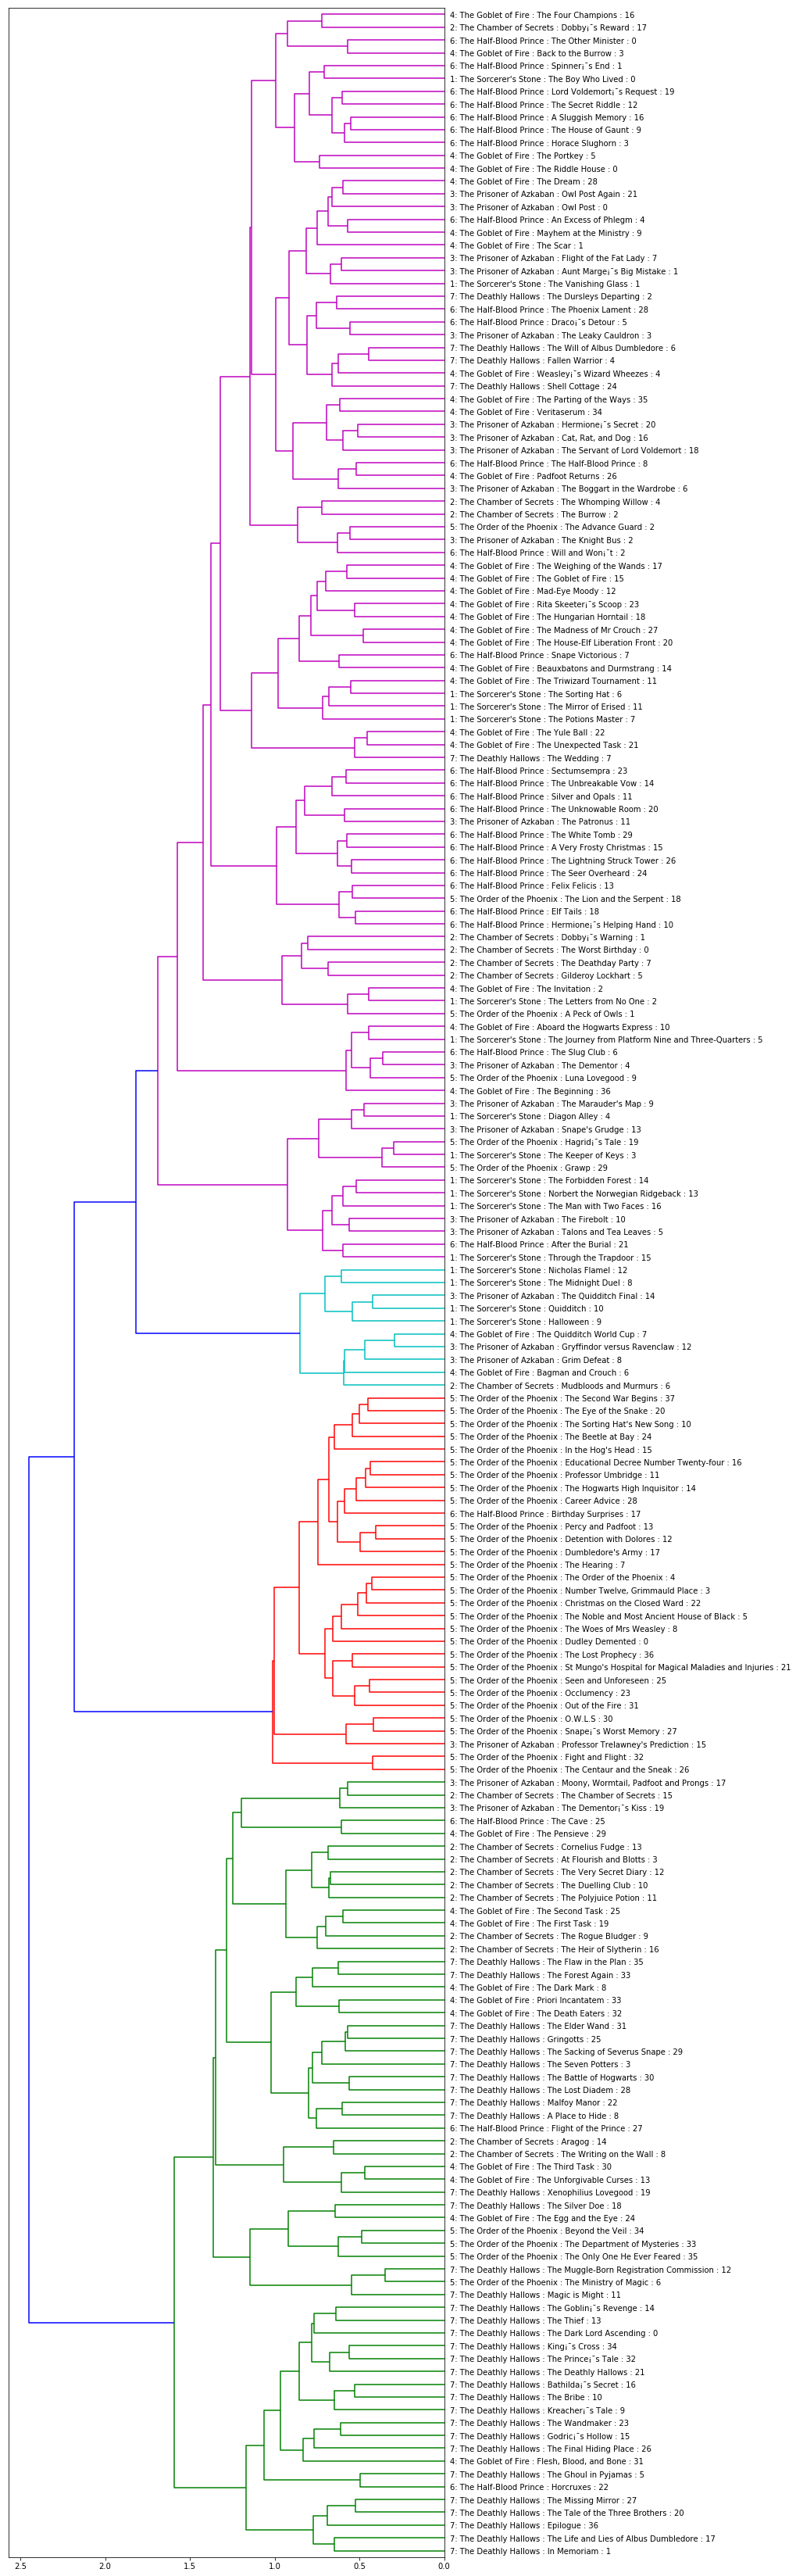

In [51]:
plot_tree(TREE, labels)

# Save

In [52]:
with sqlite3.connect(db_file) as db:
    bags.to_sql('bag', db, if_exists='replace', index=True)